In [1]:
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the CSV file
mobile_money_transaction = pd.read_csv('mobile_transactions.csv')

# Calculate the number of elements to select (10% of the dataset)
num_to_select = int(len(mobile_money_transaction) * 0.01)

# Randomly select 10% of the dataset
mobile_money_transaction = mobile_money_transaction.sample(n=num_to_select, random_state=42)

mobile_money_transaction.shape

(63626, 11)

In [3]:
# Check for missing values
print("\nMissing values per column:")
print(mobile_money_transaction.isnull().sum())


Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [4]:
# Describe numerical features
mobile_money_transaction.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,63626.000000,6.362600e+04,6.362600e+04,6.362600e+04,6.362600e+04,6.362600e+04,63626.000000,63626.000000
mean,243.566184,1.786235e+05,8.371806e+05,8.591415e+05,1.090121e+06,1.212517e+06,0.001367,0.000016
std,142.874989,5.250773e+05,2.907155e+06,2.942573e+06,3.026498e+06,3.240527e+06,0.036953,0.003964
min,1.000000,9.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,155.000000,1.358053e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,239.000000,7.595040e+04,1.358400e+04,0.000000e+00,1.423221e+05,2.201724e+05,0.000000,0.000000
75%,335.000000,2.095599e+05,1.065649e+05,1.464815e+05,9.629542e+05,1.128922e+06,0.000000,0.000000
max,736.000000,3.697390e+07,3.359321e+07,3.388709e+07,1.540135e+08,1.542411e+08,1.000000,1.000000


In [5]:
# Analyze categorical features
print("Unique values in categorical features:\n")
for col in mobile_money_transaction.select_dtypes(include=['object']).columns:
    print(f"{col}: {mobile_money_transaction[col].nunique()} unique values")

Unique values in categorical features:

type: 5 unique values
nameOrig: 63626 unique values
nameDest: 60595 unique values


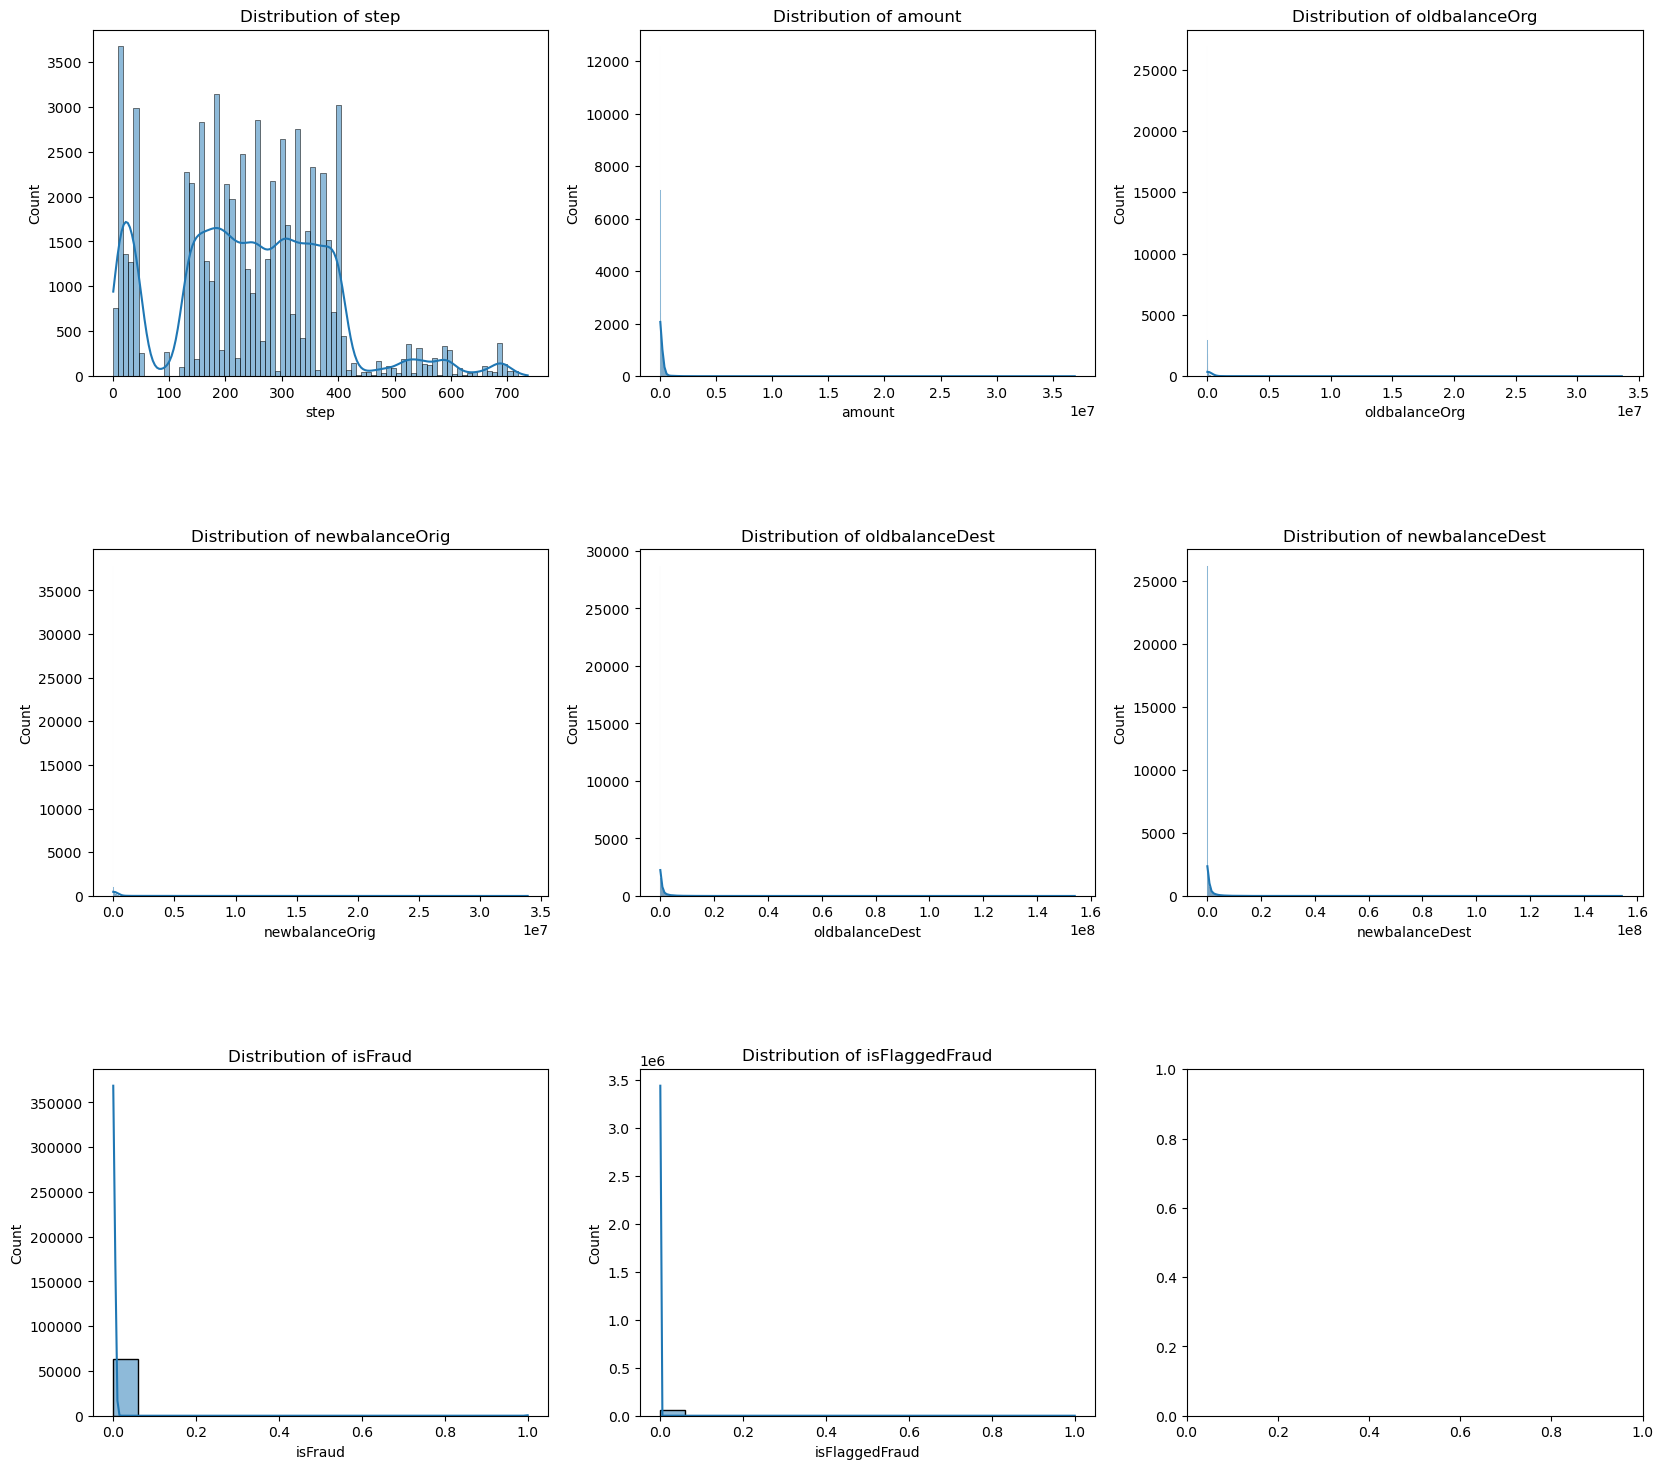

In [6]:
# Extract numerical columns
numerical_cols = mobile_money_transaction.select_dtypes(include=[np.number]).columns

# Create a grid of subplots
num_cols = 3  # Number of columns in the grid
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols  # Number of rows in the grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

# Flatten the axs if it's a non-uniform grid
if num_rows == 1:
    axs = axs.flatten()
else:
    axs = axs.ravel()

# Iterate over numerical columns and plot distributions
for i, col in enumerate(numerical_cols):
    sns.histplot(data=mobile_money_transaction, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {col}")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

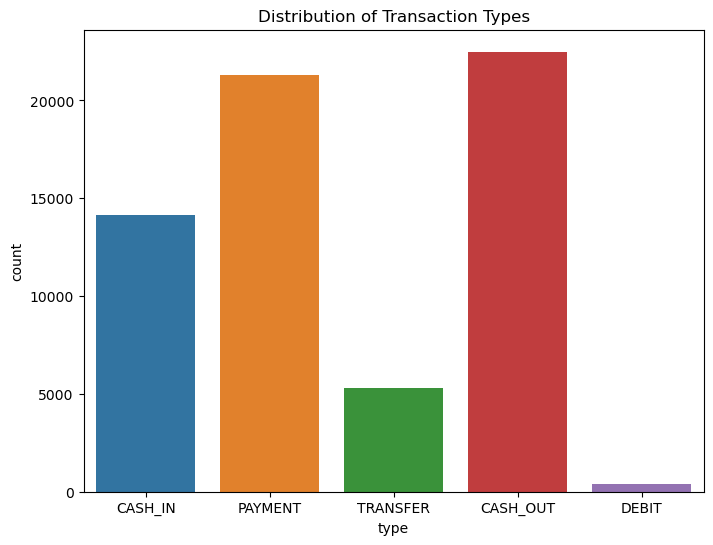

In [7]:
# Visualize categorical features
plt.figure(figsize=(8, 6))
sns.countplot(data=mobile_money_transaction, x='type')
plt.title("Distribution of Transaction Types")
plt.show()

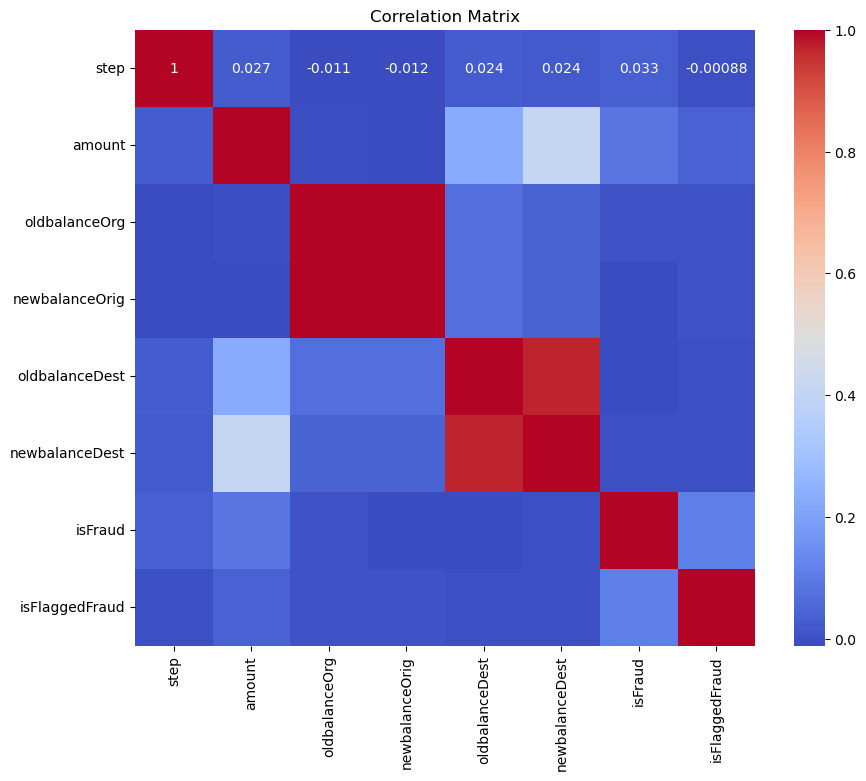

In [8]:
# Check for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(mobile_money_transaction[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [9]:
def generate_synthetic_data(data, num_samples):
    # Extract relevant features from the dataset
    features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
    
    # Filter out rows with missing values in the relevant features
    data_filtered = data.dropna(subset=features)
    
    # Compute the mean and covariance matrix of the filtered data
    mean = data_filtered[features].mean().values
    cov = data_filtered[features].cov().values
    
    # Generate synthetic feature samples using multivariate normal distribution
    synthetic_features = multivariate_normal.rvs(mean=mean, cov=cov, size=num_samples)
    
    # Create a DataFrame with the synthetic feature samples
    synthetic_data = pd.DataFrame(synthetic_features, columns=features)
    
    # Generate synthetic age based on the synthetic features
    synthetic_data['age'] = synthetic_data.apply(lambda row: generate_age(row), axis=1)
    
    # Generate synthetic gender based on the synthetic features
    synthetic_data['gender'] = synthetic_data.apply(lambda row: generate_gender(row), axis=1)
    
    # Generate synthetic user_id with the format "RW-XXXXX"
    synthetic_data['user_id'] = generate_user_ids(num_samples)
    
    return synthetic_data

def generate_user_ids(num_samples):
    user_ids = []
    unique_ids = set()
    
    while len(unique_ids) < 10000:
        user_id = 'RW-' + ''.join(random.choices(string.digits, k=5))
        unique_ids.add(user_id)
    
    user_ids = list(unique_ids)
    
    # Randomly assign user_ids to the synthetic samples
    assigned_user_ids = random.choices(user_ids, k=num_samples)
    
    return assigned_user_ids

def generate_age(row):
    # Define age group probabilities based on the synthetic features
    age_group_probs = {
        '18-25': max(0, min(1, 0.2 * np.log1p(row['amount']) - 0.1 * np.log1p(row['oldbalanceOrg']))),
        '26-35': max(0, min(1, 0.3 * np.log1p(row['amount']) + 0.2 * np.log1p(row['oldbalanceOrg']))),
        '36-45': max(0, min(1, 0.25 * np.log1p(row['amount']) - 0.1 * np.log1p(row['oldbalanceOrg']))),
        '46-55': max(0, min(1, 0.15 * np.log1p(row['amount']) + 0.1 * np.log1p(row['oldbalanceOrg']))),
        '56+': max(0, min(1, 0.1 * np.log1p(row['amount']) - 0.2 * np.log1p(row['oldbalanceOrg'])))
    }
    
    # Normalize the probabilities
    total_prob = sum(age_group_probs.values())
    age_group_probs = {k: v / total_prob for k, v in age_group_probs.items()}
    
    # Select an age group based on the probabilities
    age_group = random.choices(list(age_group_probs.keys()), weights=list(age_group_probs.values()))[0]
    
    # Generate a random age within the selected age group
    if age_group == '16-18':
        return random.randint(18, 25)
    elif age_group == '18-25':
        return random.randint(18, 25)
    elif age_group == '26-35':
        return random.randint(26, 35)
    elif age_group == '36-45':
        return random.randint(36, 45)
    elif age_group == '46-55':
        return random.randint(46, 55)
    else:
        return random.randint(56, 80)

def generate_gender(row):
    # Define gender probabilities based on the synthetic features
    gender_probs = {
        'Male': max(0, min(1, 0.1 * np.log1p(row['amount']) + 0.2 * np.log1p(row['newbalanceOrig']))),
        'Female': max(0, min(1, 0.2 * np.log1p(row['amount']) - 0.1 * np.log1p(row['newbalanceOrig'])))
    }
    
    # Normalize the probabilities
    total_prob = sum(gender_probs.values())
    gender_probs = {k: v / total_prob for k, v in gender_probs.items()}
    
    # Select a gender based on the probabilities
    gender = random.choices(list(gender_probs.keys()), weights=list(gender_probs.values()))[0]
    
    return gender

In [10]:
# Generate synthetic data
num_synthetic_samples = len(mobile_money_transaction)
synthetic_data = generate_synthetic_data(mobile_money_transaction, num_synthetic_samples)

# Reset index of the original dataset and the synthetic data
mobile_money_transaction.reset_index(drop=True, inplace=True)
synthetic_data.reset_index(drop=True, inplace=True)

# Combine the synthetic data with the original data sample
data_with_synthetic = pd.concat([mobile_money_transaction, synthetic_data[['age', 'gender', 'user_id']]], axis=1)

In [11]:
# 1. Account age
account_age = data_with_synthetic.groupby('user_id')['step'].agg(lambda x: x.max() - x.min())
account_age.name = 'account_age'

# 2. Account balance
account_balance = data_with_synthetic.groupby('user_id')['newbalanceOrig'].last()
account_balance.name = 'account_balance'

# 3. Transaction patterns
# Number of transactions
num_transactions = data_with_synthetic.groupby('user_id')['step'].count()
num_transactions.name = 'num_transactions'

# Average transaction amount
avg_transaction_amount = data_with_synthetic.groupby('user_id')['amount'].mean()
avg_transaction_amount.name = 'avg_transaction_amount'

# Transaction type distribution
transaction_type_dist = data_with_synthetic.groupby(['user_id', 'type']).size().unstack(fill_value=0)
transaction_type_dist.columns = [f'transaction_type_{col}' for col in transaction_type_dist.columns]

# 4. Account activity level
activity_level = data_with_synthetic.groupby('user_id')['step'].count().apply(lambda x: 'low' if x < 10 else ('medium' if x < 50 else 'high'))
activity_level.name = 'activity_level'

# 5. Transaction velocity
# Convert 'step' column to datetime
data_with_synthetic['step'] = pd.to_datetime(data_with_synthetic['step'], unit='D', origin='2018-01-01')

# Calculate transaction velocity
transaction_velocity = data_with_synthetic.groupby(['user_id', pd.Grouper(key='step', freq='D')]).size()
transaction_velocity = transaction_velocity.reset_index()
transaction_velocity = transaction_velocity.groupby('user_id')[0].mean()
transaction_velocity.name = 'transaction_velocity'

# Merge the calculated features with the original dataset
features = pd.concat([account_age, account_balance, num_transactions, avg_transaction_amount, transaction_type_dist, activity_level, transaction_velocity], axis=1)
data_with_features = data_with_synthetic.merge(features, left_on='user_id', right_index=True)

In [12]:
# Normalize numerical features
numeric_features = ['account_age', 'account_balance', 'num_transactions', 'avg_transaction_amount', 'transaction_velocity']
scaler = MinMaxScaler()
data_with_features[numeric_features] = scaler.fit_transform(data_with_features[numeric_features])

# Extract the day of the week from the 'step' column
data_with_features['day_of_week'] = data_with_features['step'].dt.dayofweek

# Calculate the time since last transaction for each user
data_with_features['time_since_last_transaction'] = data_with_features.groupby('user_id')['step'].diff().dt.total_seconds().fillna(0)

# Create interaction feature between transaction amount and account balance
data_with_features['amount_balance_interaction'] = data_with_features['amount'] * data_with_features['account_balance']

# Create interaction feature between transaction type and account age
data_with_features['type_age_interaction'] = data_with_features['type'].astype(str) + '_' + data_with_features['account_age'].astype(str)

# Calculate the ratio of incoming to outgoing transactions for each user
incoming_transactions = data_with_features[data_with_features['type'] == 'CASH_IN'].groupby('user_id')['amount'].mean()
outgoing_transactions = data_with_features[data_with_features['type'].isin(['CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'])].groupby('user_id')['amount'].mean()
data_with_features['incoming_outgoing_ratio'] = (incoming_transactions / outgoing_transactions).fillna(0)

# Calculate the ratio of high-value transactions for each user
high_value_threshold = 1000  # Adjust this threshold based on your data
data_with_features['high_value_ratio'] = (data_with_features['amount'] > high_value_threshold).groupby(data_with_features['user_id']).transform('mean')

# Group the data by user_id and calculate aggregated features
aggregated_features = data_with_features.groupby('user_id').agg({
    'account_age': 'last',
    'account_balance': 'last',
    'num_transactions': 'last',
    'avg_transaction_amount': 'last',
    'transaction_type_CASH_IN': 'last',
    'transaction_type_CASH_OUT': 'last',
    'transaction_type_DEBIT': 'last',
    'transaction_type_PAYMENT': 'last',
    'transaction_type_TRANSFER': 'last',
    'activity_level': 'last',
    'transaction_velocity': 'last',
    'age': 'last',
    'gender': 'last',
    'day_of_week': 'mean',
    'time_since_last_transaction': 'mean',
    'amount_balance_interaction': 'mean',
    'high_value_ratio': 'last',
    'isFraud': 'sum'
}).reset_index()

# Rename the 'isFraud' column to 'fraud_ratio'
aggregated_features = aggregated_features.rename(columns={'isFraud': 'fraud_ratio'})

# Print the aggregated features DataFrame
aggregated_features.shape

(9981, 19)

In [13]:
# Describe numerical features
aggregated_features.describe()

,account_age,account_balance,num_transactions,avg_transaction_amount,transaction_type_CASH_IN,transaction_type_CASH_OUT,transaction_type_DEBIT,transaction_type_PAYMENT,transaction_type_TRANSFER,transaction_velocity,age,day_of_week,time_since_last_transaction,amount_balance_interaction,high_value_ratio,fraud_ratio
count,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9981.000000,9.981000e+03,9981.000000,9981.00000,9981.000000
mean,0.482516,0.025381,0.255939,0.041865,1.414788,2.253181,0.040377,2.136459,0.529907,0.015212,39.946599,3.018694,5.344272e+03,4420.029871,0.97754,0.008717
std,0.203325,0.087793,0.119730,0.051703,1.192191,1.495592,0.199380,1.471443,0.724487,0.056596,15.306169,0.880216,3.495196e+06,19946.257571,0.06542,0.092959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,-2.280960e+07,0.000000,0.00000,0.000000
25%,0.342580,0.000000,0.190476,0.020781,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,27.000000,2.444444,-1.814400e+06,0.000000,1.00000,0.000000
50%,0.486824,0.000000,0.238095,0.031288,1.000000,2.000000,0.000000,2.000000,0.000000,0.000000,38.000000,3.000000,0.000000e+00,0.000000,1.00000,0.000000
75%,0.568655,0.004606,0.333333,0.046455,2.000000,3.000000,0.000000,3.000000,1.000000,0.000000,50.000000,3.583333,1.802057e+06,533.388983,1.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,8.000000,9.000000,2.000000,10.000000,5.000000,1.000000,80.000000,6.000000,1.779840e+07,544491.510947,1.00000,1.000000


In [14]:
# Analyze categorical features
print("Unique values in categorical features:\n")
for col in aggregated_features.select_dtypes(include=['object']).columns:
    print(f"{col}: {aggregated_features[col].nunique()} unique values")

Unique values in categorical features:

user_id: 9981 unique values
activity_level: 2 unique values
gender: 2 unique values


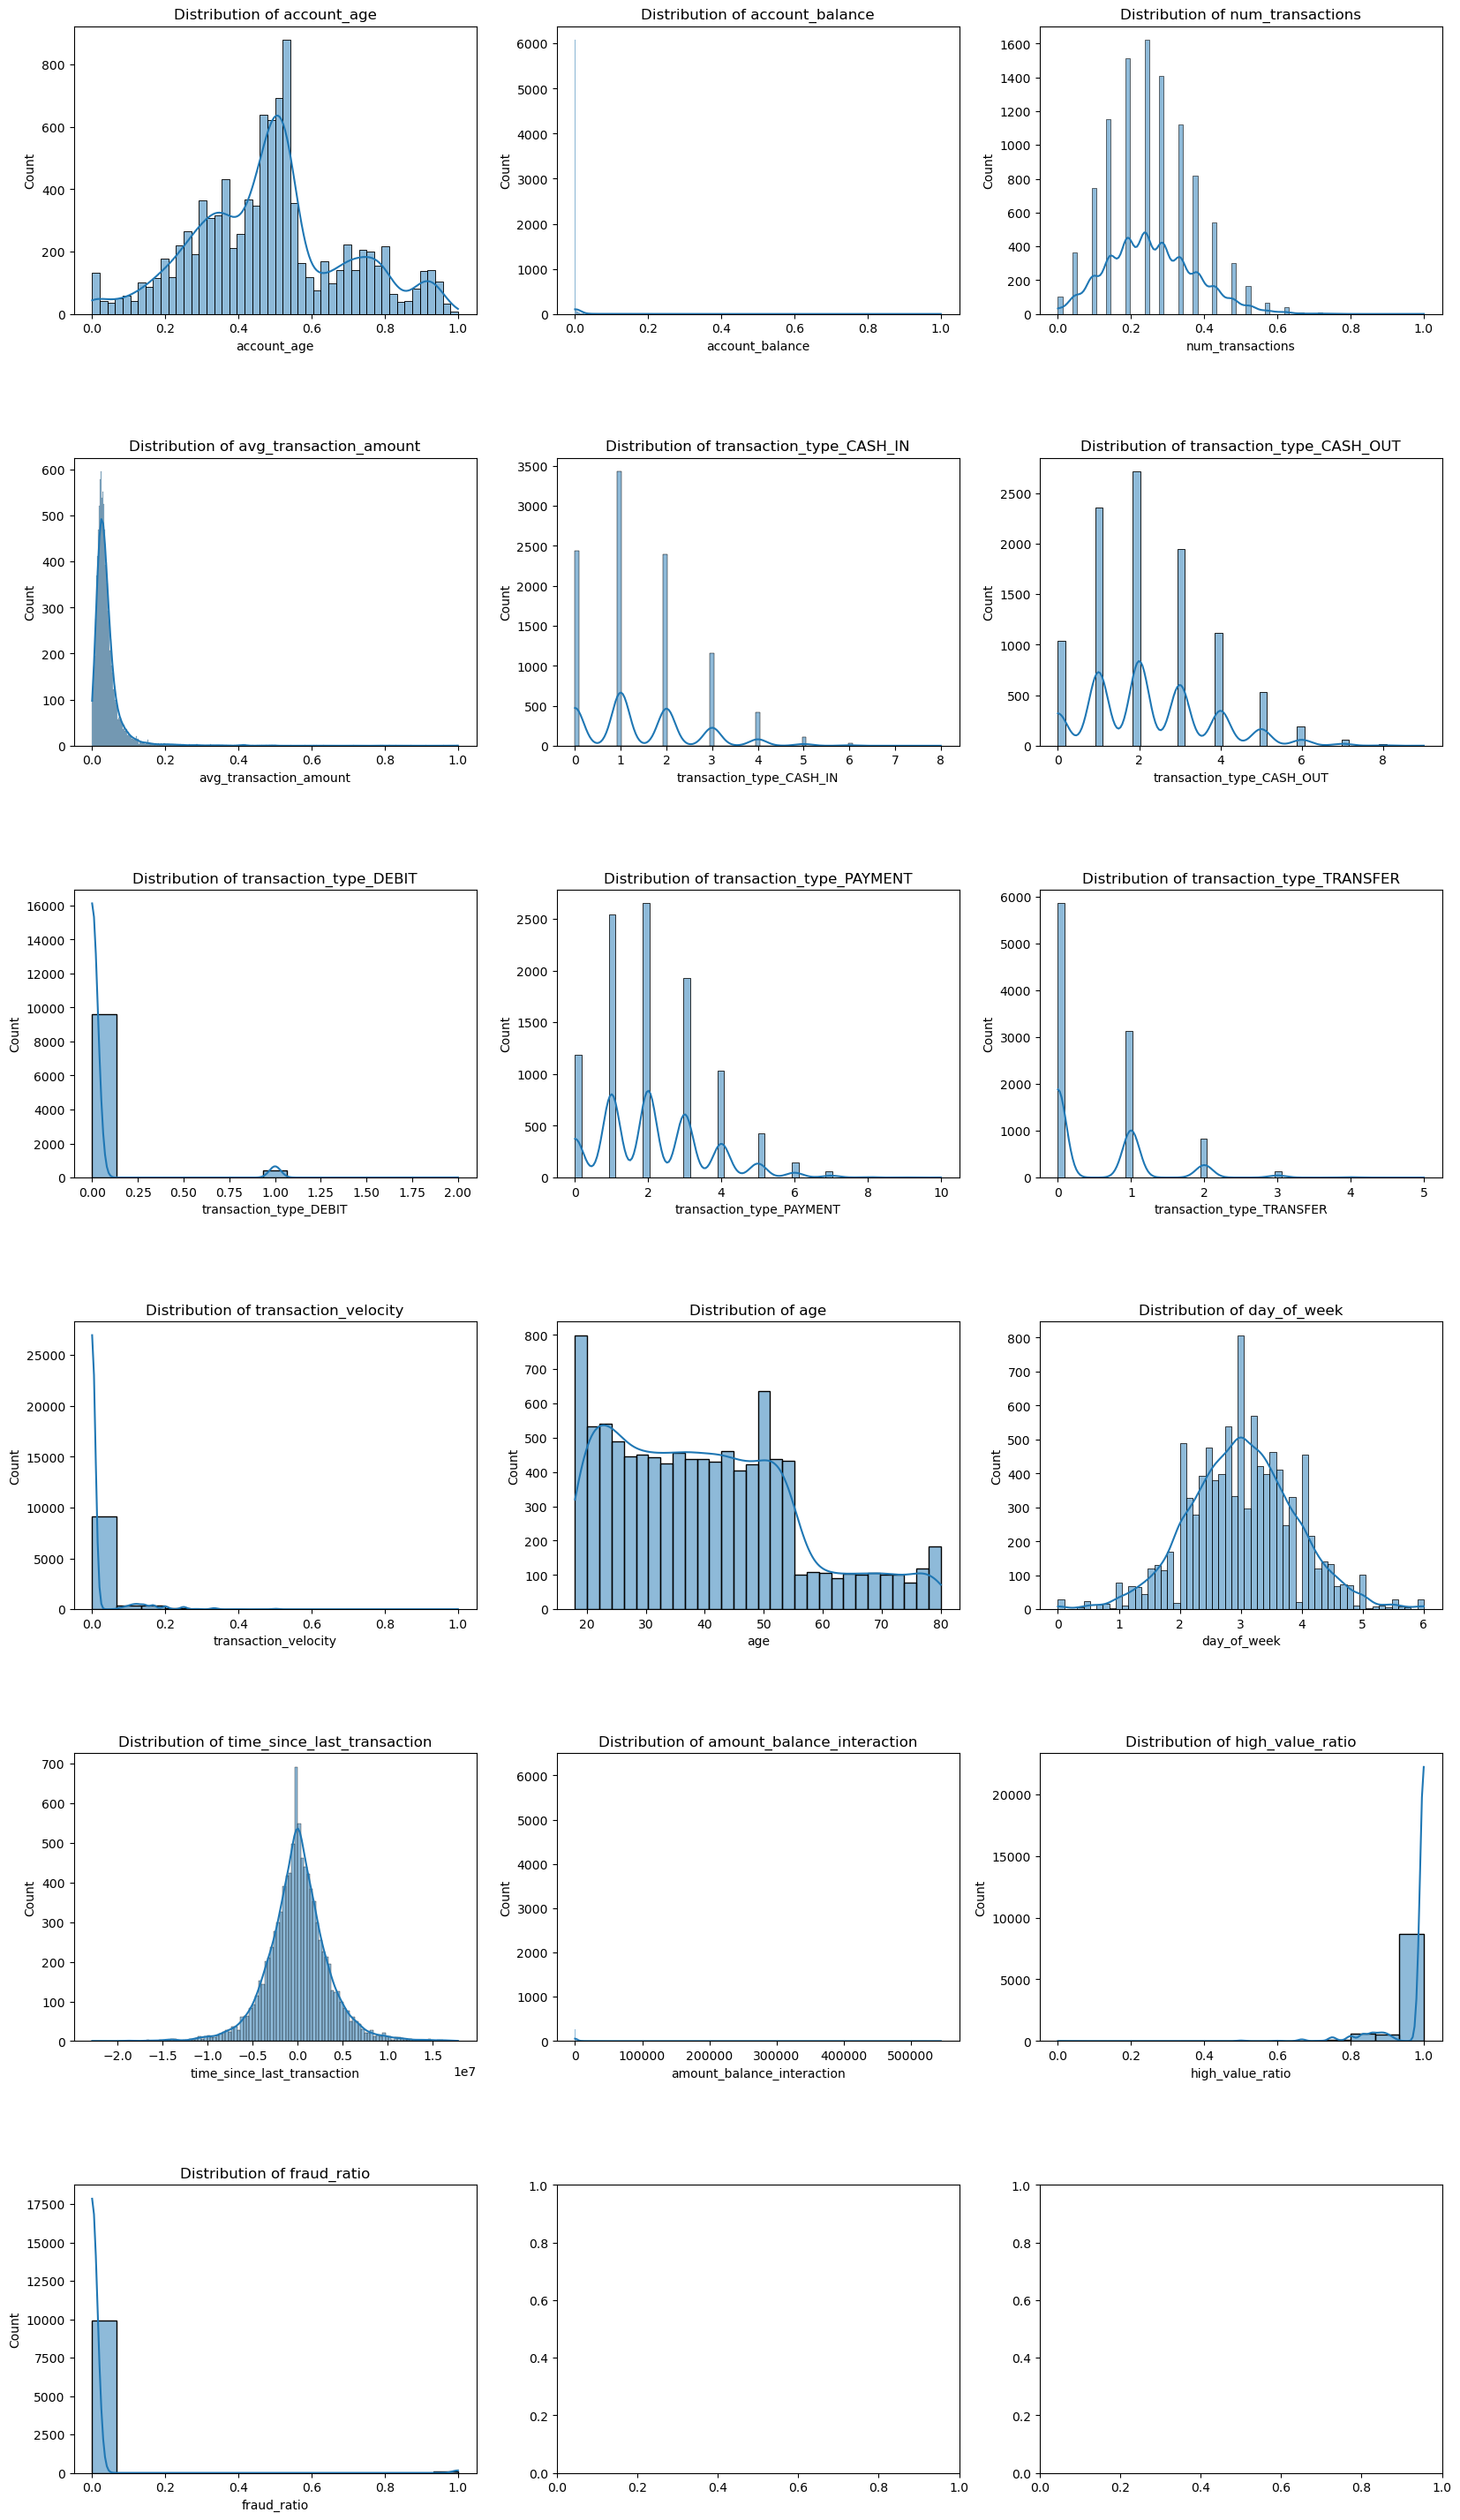

In [15]:
# Extract numerical columns
numerical_cols = aggregated_features.select_dtypes(include=[np.number]).columns

# Create a grid of subplots
num_cols = 3  # Number of columns in the grid
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols  # Number of rows in the grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))

# Flatten the axs if it's a non-uniform grid
if num_rows == 1:
    axs = axs.flatten()
else:
    axs = axs.ravel()

# Iterate over numerical columns and plot distributions
for i, col in enumerate(numerical_cols):
    sns.histplot(data=aggregated_features, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {col}")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

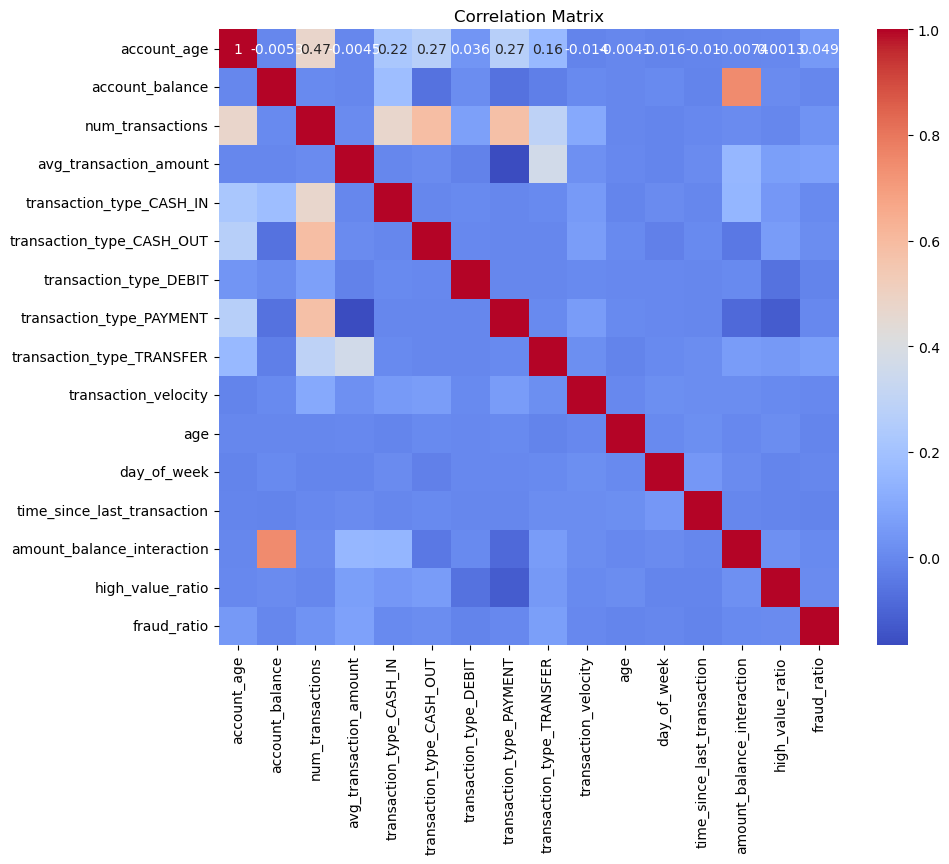

In [16]:
# Check for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(aggregated_features[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [17]:
# Outlier Detection and Treatment
numerical_cols = ['account_balance', 'num_transactions', 'avg_transaction_amount', 'transaction_velocity']
for col in numerical_cols:
    z_scores = np.abs(stats.zscore(aggregated_features[col]))
    threshold = 3  # Adjust this value based on your requirements
    outliers = aggregated_features[z_scores > threshold]
    print(f"Number of outliers in {col}: {len(outliers)}")

    # Replace outliers with the median value (you can choose other strategies as well)
    aggregated_features.loc[z_scores > threshold, col] = aggregated_features[col].median()

Number of outliers in account_balance: 231
Number of outliers in num_transactions: 60
Number of outliers in avg_transaction_amount: 155
Number of outliers in transaction_velocity: 253


In [18]:
# One-hot encode categorical features
categorical_cols = ['activity_level', 'gender']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Create a copy of the DataFrame to avoid modifying the original
X = aggregated_features.drop(['fraud_ratio', 'user_id'], axis=1).copy()

# One-hot encode categorical columns
categorical_data = X[categorical_cols]
numerical_data = X.drop(categorical_cols, axis=1)

one_hot_encoded = one_hot_encoder.fit_transform(categorical_data)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Combine one-hot encoded and numerical data
X = pd.concat([numerical_data, one_hot_encoded_df], axis=1)

y = aggregated_features['fraud_ratio']

In [19]:
# Recursive Feature Elimination
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
print("Selected features (RFE):", selected_features_rfe)

# LASSO Feature Selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
selected_features_lasso = X.columns[lasso.coef_ != 0]
print("Selected features (LASSO):", selected_features_lasso)

Selected features (RFE): Index(['account_age', 'account_balance', 'num_transactions',
       'avg_transaction_amount', 'transaction_type_CASH_OUT',
       'transaction_type_DEBIT', 'transaction_type_TRANSFER',
       'high_value_ratio', 'activity_level_low', 'activity_level_medium'],
      dtype='object')
Selected features (LASSO): Index(['time_since_last_transaction'], dtype='object')


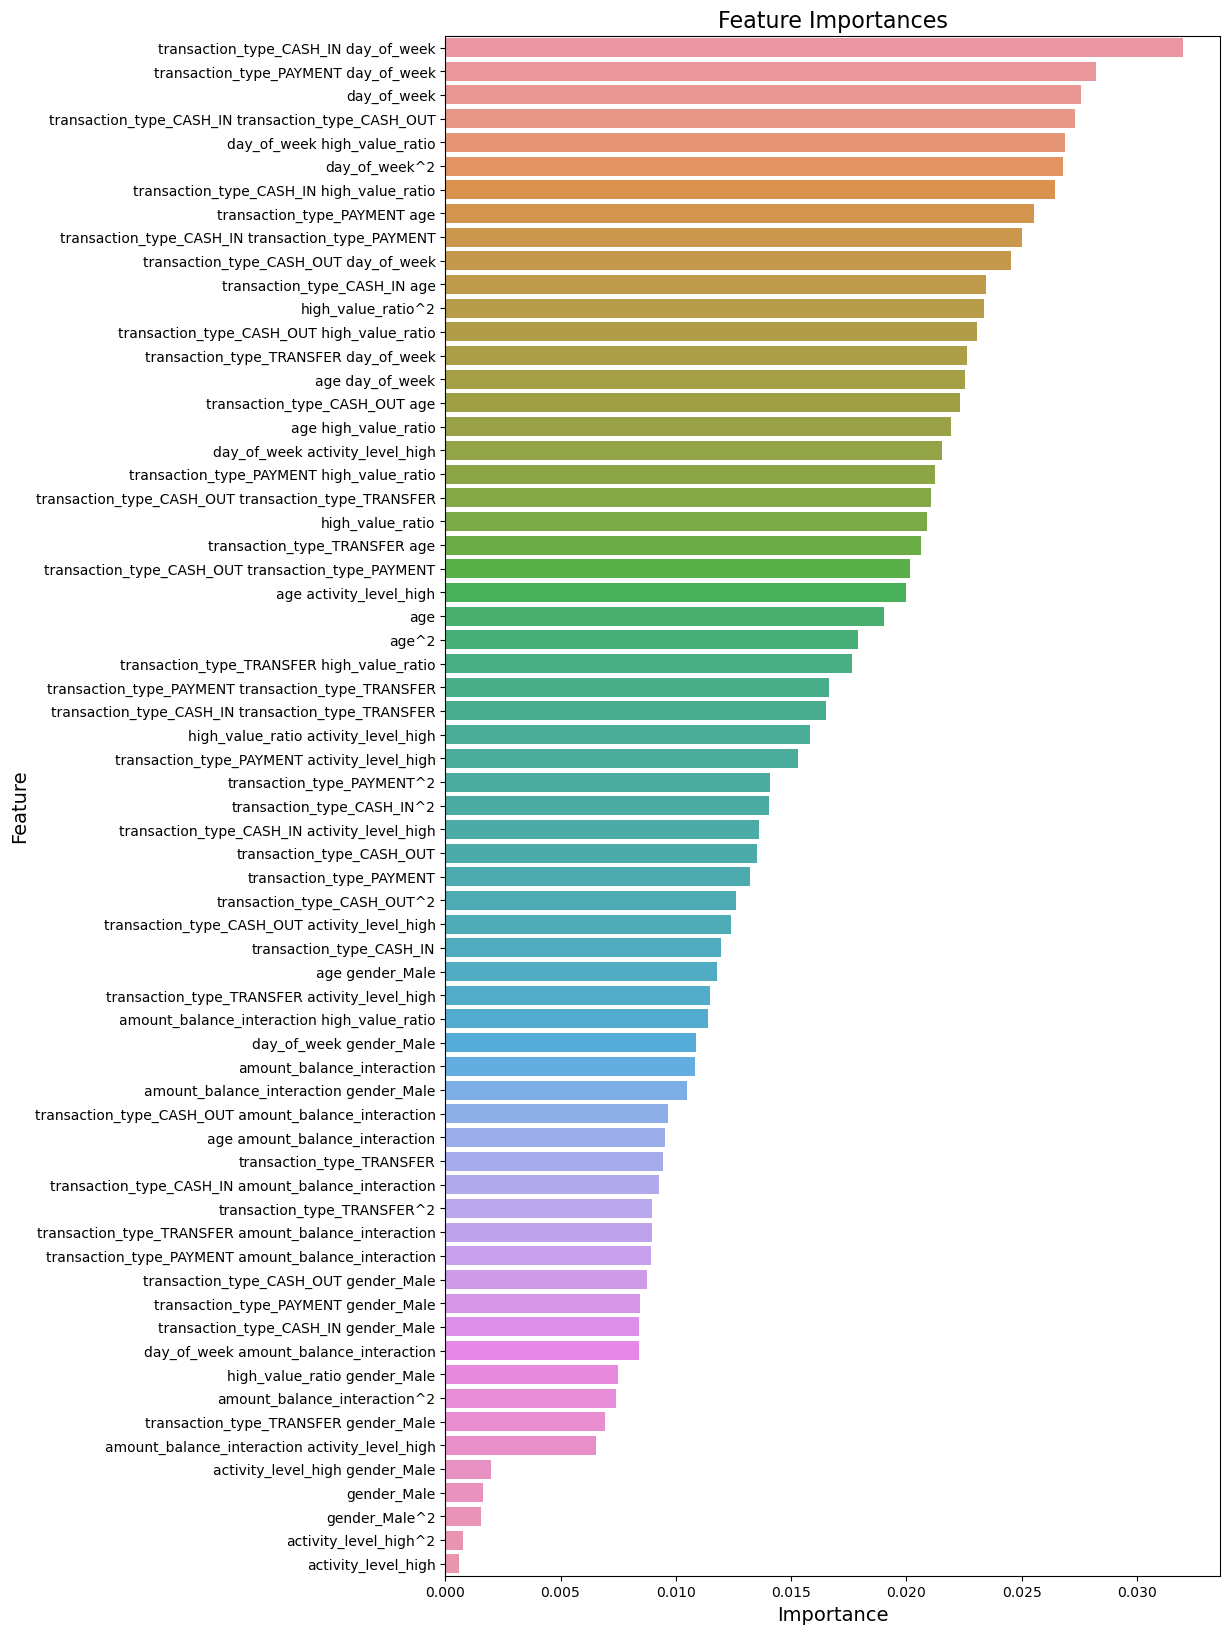

In [20]:
# # Nonlinear Feature Transformations
# # poly_features = PolynomialFeatures(degree=2, include_bias=False)
# # X_poly = poly_features.fit_transform(X[selected_features_rfe])
# X_poly = X[selected_features_rfe]

# # Feature Importance Analysis
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_poly, y)
# feature_importances = rf.feature_importances_

# feature_names = np.array(selected_features_rfe)
# poly_feature_names = poly_features.get_feature_names_out(feature_names)

# # Create a DataFrame to store feature names and importances
# feature_imp_df = pd.DataFrame({'Feature': poly_feature_names, 'Importance': feature_importances})

# # Sort the DataFrame by feature importance in descending order
# feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# # Visualize feature importances using a horizontal bar plot
# plt.figure(figsize=(10, 20))
# sns.barplot(x='Importance', y='Feature', data=feature_imp_df, orient='h')
# plt.title('Feature Importances', fontsize=16)
# plt.xlabel('Importance', fontsize=14)
# plt.ylabel('Feature', fontsize=14)
# plt.show()

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Assuming `selected_features_rfe` and `X`, `y` are defined earlier in your code

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(selected_features_rfe, y, test_size=0.2, random_state=42)

# Fit the model with the selected features
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Extract probabilities for the positive class
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC score with the best value of N: {auc_score:.4f}")

# Analyze feature importance
feature_importances = xgb_model.feature_importances_
print("Feature importances:")

# Print the top important feature names and their importance scores
for feature, importance in zip(top_features, feature_importances):
    print(f"{feature}: {importance:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [10, 9981]

In [28]:
# Define your XGBClassifier model
xgb_model = XGBClassifier()

X_poly_top = X[selected_features_rfe]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_top, y, test_size=0.2, random_state=42)

# Fit the model with the selected features
xgb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Extract probabilities for the positive class
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC score with the best value of N: {auc_score:.4f}")

AUC-ROC score with the best value of N: 0.6663


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# best_N = 10

# # Select the top N important features based on the best value obtained from grid search
# top_features = feature_imp_df['Feature'].head(best_N).tolist()
# top_feature_indices = feature_imp_df.index[:best_N].tolist()
# X_poly_top = X_poly[:, top_feature_indices]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_top, y, test_size=0.2, random_state=42)

# Fit the model with the selected features
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_proba]

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.2f}")

# Calculate AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC score with the best value of N: {auc_score:.4f}")

# # Analyze feature importance
# feature_importances = xgb_model.feature_importances_
# print("Feature importances:")

# # Print the top important feature names and their importance scores
# for feature, importance in zip(top_features, feature_importances):
#     print(f"{feature}: {importance:.4f}")

Precision: 0.00
Recall: 0.00
F1-score: 0.00
AUC-ROC score with the best value of N: 0.6663


AUC-ROC score: 0.6663


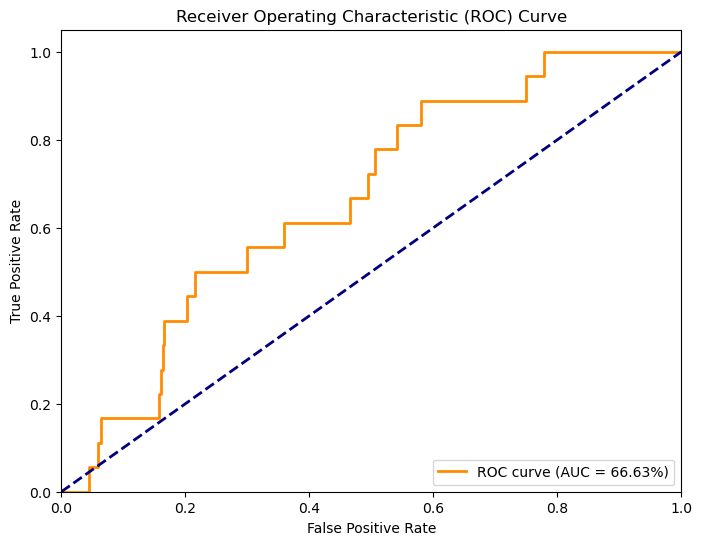

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC-ROC score
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC score: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {100 * roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

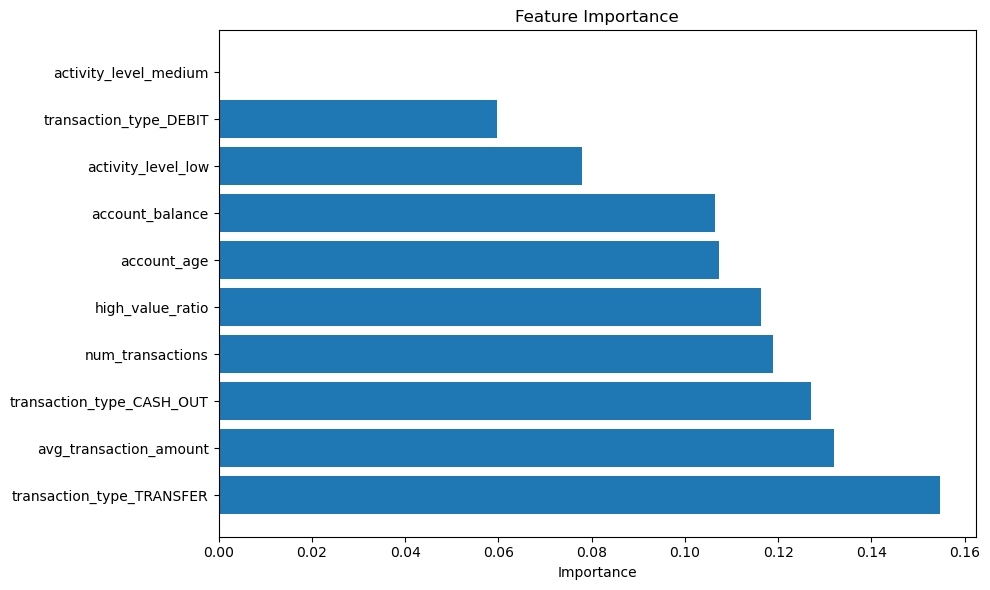

In [35]:
import matplotlib.pyplot as plt

# Get the feature importances from the XGBoost model
feature_importances = xgb_model.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to display feature names and importances
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importance in descending order
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_imp_df)), feature_imp_df['Importance'], align='center')
plt.yticks(range(len(feature_imp_df)), feature_imp_df['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

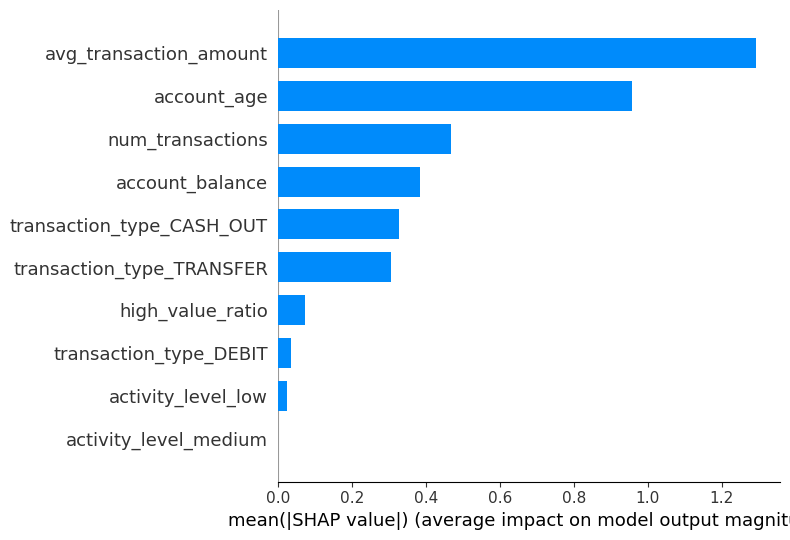

In [36]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

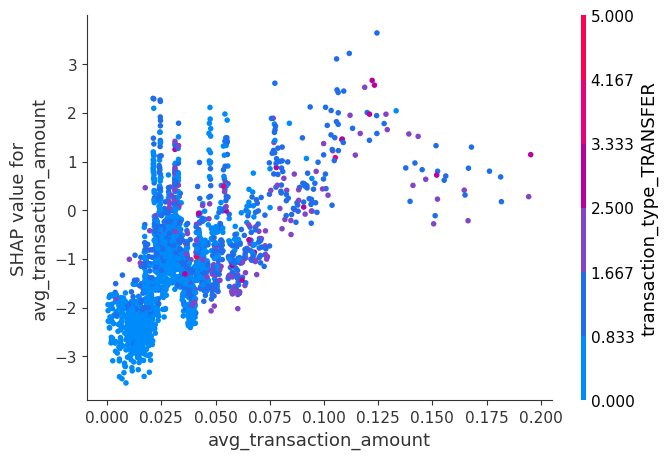

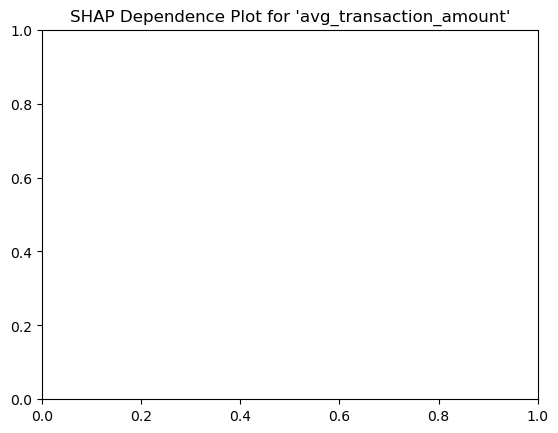

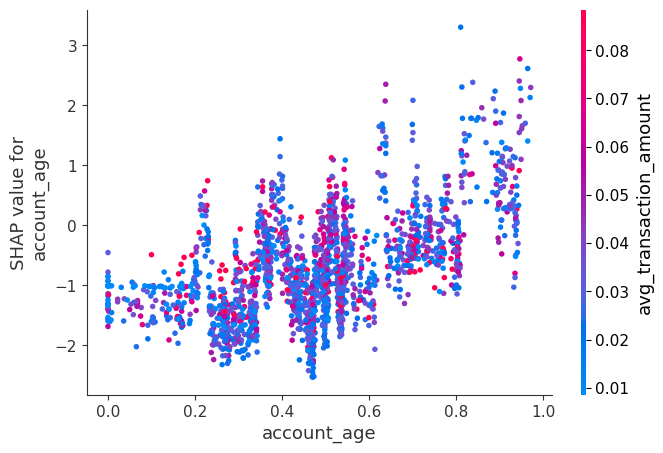

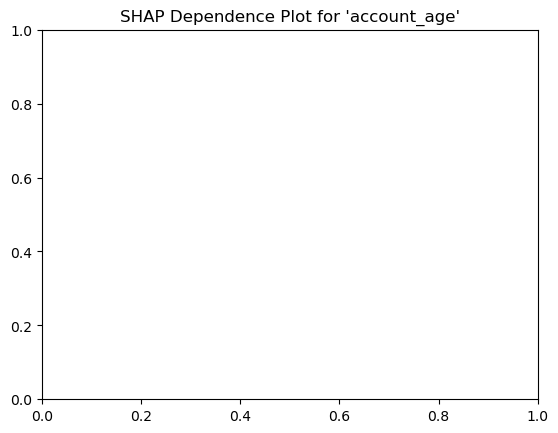

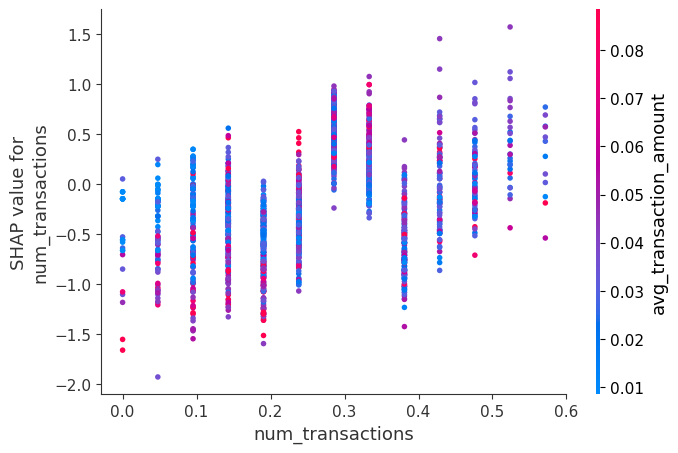

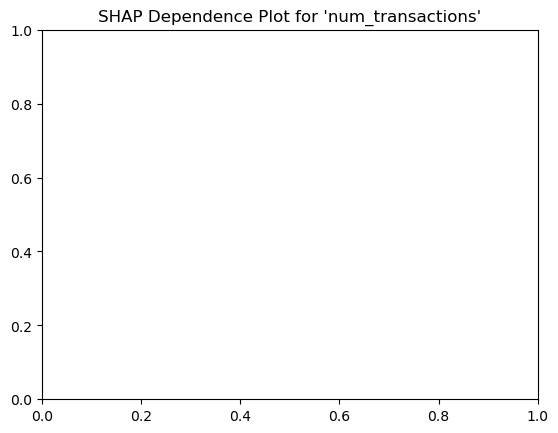

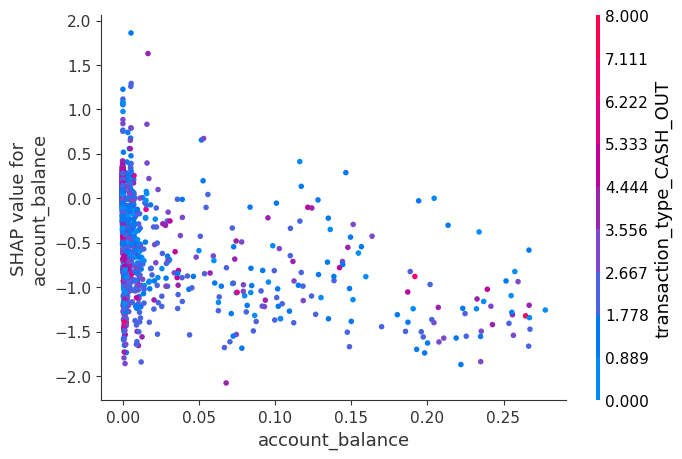

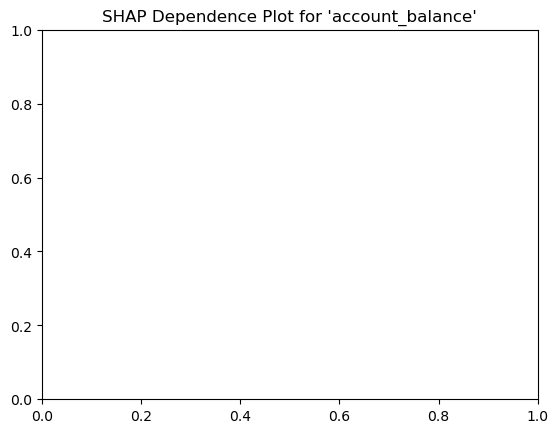

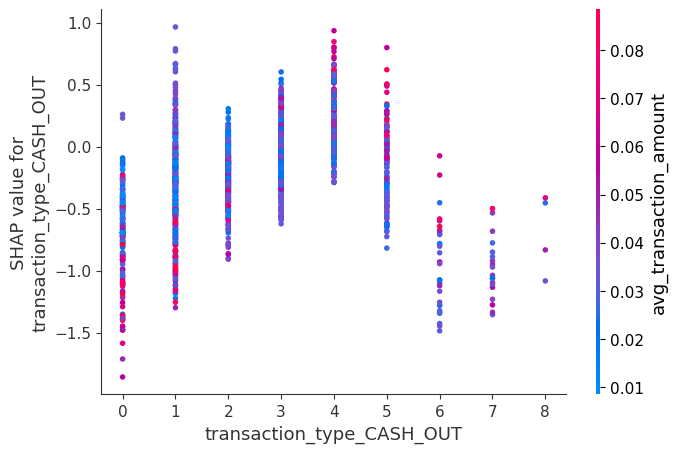

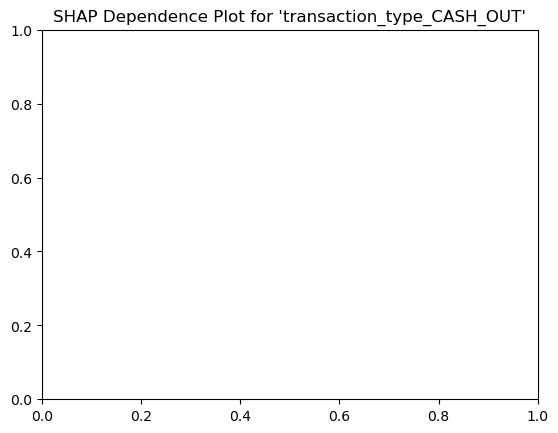

In [50]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Select the top influential features
top_features = ['avg_transaction_amount', 'account_age', 'num_transactions', 'account_balance', 'transaction_type_CASH_OUT']

# Plot the SHAP dependence plots for the top features
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_test)
    plt.title(f"SHAP Dependence Plot for '{feature}'")
    plt.show()

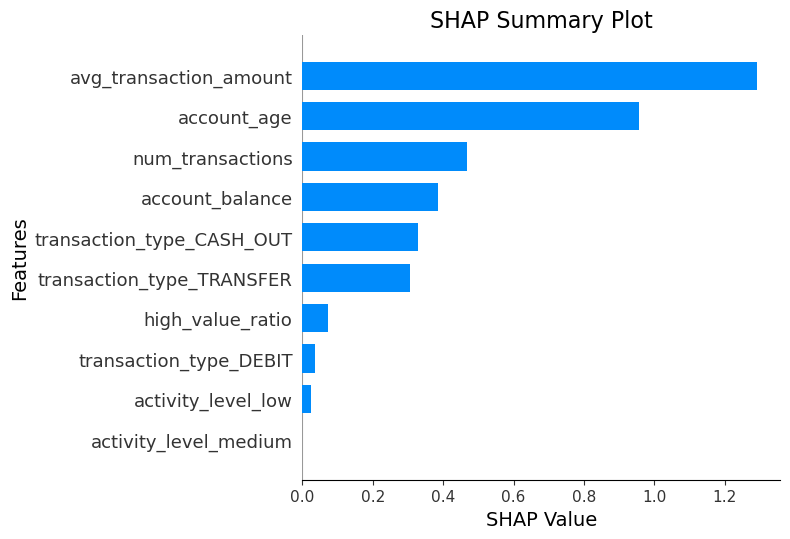

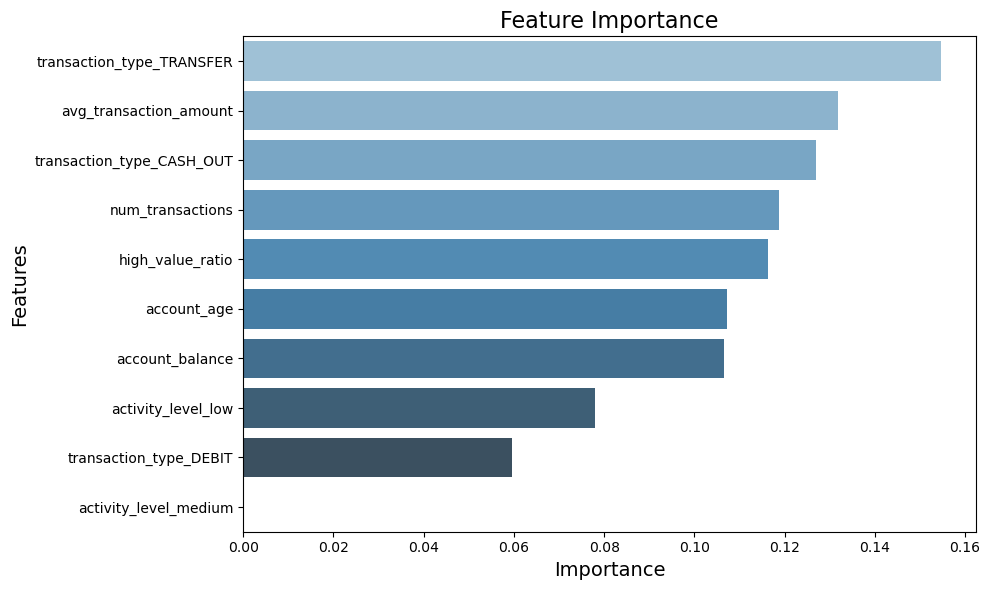

In [45]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary Plot", fontsize=16)
plt.xlabel("SHAP Value", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")

# Get the feature importances from the XGBoost model
feature_importances = xgb_model.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to display feature names and importances
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importance in descending order
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance as a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp_df, x="Importance", y="Feature", palette="Blues_d", orient="h")
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.tight_layout()
plt.savefig("feature_importance_plot.png", dpi=300, bbox_inches="tight")